# IMPORTING THE LIBRARIES

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import secrets
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.applications.vgg16 import VGG16

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

# Defining the train,test and model directories

We will create the directories for train,test and model training paths if not present

In [2]:
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

In [4]:
# Setting the data augmentation definition

gen_per_image = 1
gen_per_class = 200
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

In [5]:

height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def change_contrast(img, level):
    img = Image.fromarray(img.astype('uint8'))
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))

def pad_img(img):
    h, w = img.shape[:2]
    new_h = int((5 + secrets.randbelow(16)) * h / 100) + h
    new_w = int((5 + secrets.randbelow(16)) * w / 100) + w

    full_sheet = np.ones((new_h, new_w, 3)) * 255

    p_X = secrets.randbelow(new_h - img.shape[0])
    p_Y = secrets.randbelow(new_w - img.shape[1])

    full_sheet[p_X : p_X + img.shape[0], p_Y : p_Y + img.shape[1]] = img

    full_sheet = cv2.resize(full_sheet, (w, h), interpolation = cv2.INTER_AREA)

    return full_sheet.astype(np.uint8)

def preprocess_img(img):
    img = np.array(img)

    x = secrets.randbelow(2)

    if x == 0:
        # img = pad_img(img)
        img = increase_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
    else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = increase_brightness(img, secrets.randbelow(26))

    return img


In [6]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
NUM_EPOCH = 400

In [7]:
#Initialise the parameters for Augmentation.
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode,
        validation_split = 0.2,
        preprocessing_function = preprocess_img)


train_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='training',shuffle=False)

valid_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='validation',shuffle=False)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


# Defining the Model

In [8]:
model = VGG16(include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
train_vgg16 = model.predict(train_data,verbose=1)
valid_vgg16 = model.predict(valid_data,verbose=1)

2023-01-31 16:24:32.839046: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


36/36 [==============================] - 452s 12s/step


In [11]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (17943, 7, 7, 512)
Validation shape (4481, 7, 7, 512)


In [12]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0]

In [13]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (7, 7, 512)
Validation features shape (7, 7, 512)


In [14]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


In [15]:
VGG16_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [16]:
plot_model(VGG16_model,to_file=os.path.join(os.getcwd(),"model","vgg16","model_distracted_driver_vgg16.png"),show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [18]:
model_history = VGG16_model.fit(train_vgg16,train_data.classes,validation_data = (valid_vgg16,valid_data.classes),epochs=400,shuffle=True,callbacks=callbacks_list)

Epoch 1/400
544/561 [============================>.] - ETA: 0s - loss: 2.6043 - accuracy: 0.4361
Epoch 1: val_accuracy improved from -inf to 0.63580, saving model to /Users/abhjha8/ml_projects/DistractedDriverDetection/model/self_trained/distracted-01-0.64.hdf5
561/561 [==============================] - 1s 2ms/step - loss: 2.5587 - accuracy: 0.4434 - val_loss: 1.2721 - val_accuracy: 0.6358
Epoch 2/400
496/561 [=========================>....] - ETA: 0s - loss: 0.7824 - accuracy: 0.7569
Epoch 2: val_accuracy improved from 0.63580 to 0.80741, saving model to /Users/abhjha8/ml_projects/DistractedDriverDetection/model/self_trained/distracted-02-0.81.hdf5
561/561 [==============================] - 1s 1ms/step - loss: 0.7585 - accuracy: 0.7636 - val_loss: 0.6293 - val_accuracy: 0.8074
Epoch 3/400
527/561 [===========================>..] - ETA: 0s - loss: 0.4838 - accuracy: 0.8488
Epoch 3: val_accuracy improved from 0.80741 to 0.83039, saving model to /Users/abhjha8/ml_projects/DistractedDrive

Epoch 27/400
495/561 [=========================>....] - ETA: 0s - loss: 0.1324 - accuracy: 0.9568
Epoch 27: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 815us/step - loss: 0.1311 - accuracy: 0.9571 - val_loss: 0.3074 - val_accuracy: 0.9203
Epoch 28/400
520/561 [==========================>...] - ETA: 0s - loss: 0.1272 - accuracy: 0.9588
Epoch 28: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 2ms/step - loss: 0.1279 - accuracy: 0.9586 - val_loss: 0.3548 - val_accuracy: 0.9065
Epoch 29/400
555/561 [============================>.] - ETA: 0s - loss: 0.1300 - accuracy: 0.9595
Epoch 29: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 1ms/step - loss: 0.1305 - accuracy: 0.9593 - val_loss: 0.2825 - val_accuracy: 0.9237
Epoch 30/400
492/561 [=========================>....] - ETA: 0s - loss: 0.1278 - accuracy: 0.9574
Epoch 30: val_accuracy did not improve from 0.93350
561/5

518/561 [==========================>...] - ETA: 0s - loss: 0.0807 - accuracy: 0.9736
Epoch 85: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 3ms/step - loss: 0.0814 - accuracy: 0.9732 - val_loss: 0.4853 - val_accuracy: 0.9156
Epoch 86/400
558/561 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9733
Epoch 86: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 2ms/step - loss: 0.0817 - accuracy: 0.9732 - val_loss: 0.5026 - val_accuracy: 0.9085
Epoch 87/400
523/561 [==========================>...] - ETA: 0s - loss: 0.0748 - accuracy: 0.9744
Epoch 87: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 2ms/step - loss: 0.0796 - accuracy: 0.9736 - val_loss: 0.5116 - val_accuracy: 0.9098
Epoch 88/400
561/561 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9739
Epoch 88: val_accuracy did not improve from 0.93350
561/561 [===========

Epoch 143/400
556/561 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9790
Epoch 143: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 801us/step - loss: 0.0626 - accuracy: 0.9791 - val_loss: 0.6446 - val_accuracy: 0.9134
Epoch 144/400
541/561 [===========================>..] - ETA: 0s - loss: 0.0634 - accuracy: 0.9784
Epoch 144: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 932us/step - loss: 0.0632 - accuracy: 0.9785 - val_loss: 0.6502 - val_accuracy: 0.9085
Epoch 145/400
545/561 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9795
Epoch 145: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 915us/step - loss: 0.0616 - accuracy: 0.9793 - val_loss: 0.6402 - val_accuracy: 0.9107
Epoch 146/400
517/561 [==========================>...] - ETA: 0s - loss: 0.0580 - accuracy: 0.9801
Epoch 146: val_accuracy did not improve from 0

Epoch 172/400
538/561 [===========================>..] - ETA: 0s - loss: 0.0560 - accuracy: 0.9808
Epoch 172: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 2ms/step - loss: 0.0563 - accuracy: 0.9808 - val_loss: 0.7316 - val_accuracy: 0.9036
Epoch 173/400
505/561 [==========================>...] - ETA: 0s - loss: 0.0546 - accuracy: 0.9830
Epoch 173: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 975us/step - loss: 0.0560 - accuracy: 0.9821 - val_loss: 0.7691 - val_accuracy: 0.9025
Epoch 174/400
518/561 [==========================>...] - ETA: 0s - loss: 0.0559 - accuracy: 0.9823
Epoch 174: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 2ms/step - loss: 0.0562 - accuracy: 0.9819 - val_loss: 0.7413 - val_accuracy: 0.9078
Epoch 175/400
561/561 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9817
Epoch 175: val_accuracy did not improve from 0.933

Epoch 201/400
560/561 [============================>.] - ETA: 0s - loss: 0.0516 - accuracy: 0.9827
Epoch 201: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 2ms/step - loss: 0.0516 - accuracy: 0.9827 - val_loss: 0.8453 - val_accuracy: 0.8994
Epoch 202/400
559/561 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.9829
Epoch 202: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 1ms/step - loss: 0.0491 - accuracy: 0.9830 - val_loss: 0.8192 - val_accuracy: 0.9060
Epoch 203/400
551/561 [============================>.] - ETA: 0s - loss: 0.0482 - accuracy: 0.9842
Epoch 203: val_accuracy did not improve from 0.93350
561/561 [==============================] - 1s 2ms/step - loss: 0.0495 - accuracy: 0.9841 - val_loss: 0.8326 - val_accuracy: 0.9078
Epoch 204/400
530/561 [===========================>..] - ETA: 0s - loss: 0.0493 - accuracy: 0.9843
Epoch 204: val_accuracy did not improve from 0.93350

Epoch 230/400
553/561 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9846
Epoch 230: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 800us/step - loss: 0.0464 - accuracy: 0.9845 - val_loss: 0.9290 - val_accuracy: 0.9016
Epoch 231/400
538/561 [===========================>..] - ETA: 0s - loss: 0.0463 - accuracy: 0.9841
Epoch 231: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 815us/step - loss: 0.0459 - accuracy: 0.9844 - val_loss: 0.9157 - val_accuracy: 0.9018
Epoch 232/400
560/561 [============================>.] - ETA: 0s - loss: 0.0442 - accuracy: 0.9846
Epoch 232: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 778us/step - loss: 0.0441 - accuracy: 0.9846 - val_loss: 0.9167 - val_accuracy: 0.9031
Epoch 233/400
497/561 [=========================>....] - ETA: 0s - loss: 0.0495 - accuracy: 0.9836
Epoch 233: val_accuracy did not improve from 0

Epoch 259/400
530/561 [===========================>..] - ETA: 0s - loss: 0.0396 - accuracy: 0.9860
Epoch 259: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 830us/step - loss: 0.0423 - accuracy: 0.9860 - val_loss: 1.0083 - val_accuracy: 0.8989
Epoch 260/400
529/561 [===========================>..] - ETA: 0s - loss: 0.0411 - accuracy: 0.9854
Epoch 260: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 819us/step - loss: 0.0410 - accuracy: 0.9853 - val_loss: 1.0100 - val_accuracy: 0.8989
Epoch 261/400
536/561 [===========================>..] - ETA: 0s - loss: 0.0447 - accuracy: 0.9857
Epoch 261: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 819us/step - loss: 0.0455 - accuracy: 0.9852 - val_loss: 1.0279 - val_accuracy: 0.8958
Epoch 262/400
546/561 [============================>.] - ETA: 0s - loss: 0.0434 - accuracy: 0.9856
Epoch 262: val_accuracy did not improve from 0

Epoch 288/400
521/561 [==========================>...] - ETA: 0s - loss: 0.0382 - accuracy: 0.9870
Epoch 288: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 837us/step - loss: 0.0388 - accuracy: 0.9871 - val_loss: 1.1369 - val_accuracy: 0.8940
Epoch 289/400
535/561 [===========================>..] - ETA: 0s - loss: 0.0413 - accuracy: 0.9870
Epoch 289: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 832us/step - loss: 0.0414 - accuracy: 0.9868 - val_loss: 1.1048 - val_accuracy: 0.8962
Epoch 290/400
557/561 [============================>.] - ETA: 0s - loss: 0.0358 - accuracy: 0.9881
Epoch 290: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 804us/step - loss: 0.0370 - accuracy: 0.9879 - val_loss: 1.0985 - val_accuracy: 0.8980
Epoch 291/400
535/561 [===========================>..] - ETA: 0s - loss: 0.0407 - accuracy: 0.9869
Epoch 291: val_accuracy did not improve from 0

Epoch 317/400
540/561 [===========================>..] - ETA: 0s - loss: 0.0344 - accuracy: 0.9881
Epoch 317: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 814us/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 1.1871 - val_accuracy: 0.8962
Epoch 318/400
532/561 [===========================>..] - ETA: 0s - loss: 0.0351 - accuracy: 0.9884
Epoch 318: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 836us/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 1.1598 - val_accuracy: 0.8991
Epoch 319/400
518/561 [==========================>...] - ETA: 0s - loss: 0.0349 - accuracy: 0.9883
Epoch 319: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 841us/step - loss: 0.0349 - accuracy: 0.9884 - val_loss: 1.1671 - val_accuracy: 0.8989
Epoch 320/400
524/561 [===========================>..] - ETA: 0s - loss: 0.0361 - accuracy: 0.9874
Epoch 320: val_accuracy did not improve from 0

Epoch 346/400
526/561 [===========================>..] - ETA: 0s - loss: 0.0308 - accuracy: 0.9900
Epoch 346: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 823us/step - loss: 0.0341 - accuracy: 0.9898 - val_loss: 1.2333 - val_accuracy: 0.8973
Epoch 347/400
539/561 [===========================>..] - ETA: 0s - loss: 0.0331 - accuracy: 0.9893
Epoch 347: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 808us/step - loss: 0.0326 - accuracy: 0.9894 - val_loss: 1.2681 - val_accuracy: 0.8960
Epoch 348/400
535/561 [===========================>..] - ETA: 0s - loss: 0.0305 - accuracy: 0.9900
Epoch 348: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 814us/step - loss: 0.0346 - accuracy: 0.9898 - val_loss: 1.2834 - val_accuracy: 0.8900
Epoch 349/400
546/561 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9902
Epoch 349: val_accuracy did not improve from 0

Epoch 375/400
522/561 [==========================>...] - ETA: 0s - loss: 0.0310 - accuracy: 0.9897
Epoch 375: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 819us/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 1.3271 - val_accuracy: 0.8929
Epoch 376/400
560/561 [============================>.] - ETA: 0s - loss: 0.0336 - accuracy: 0.9888
Epoch 376: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 794us/step - loss: 0.0335 - accuracy: 0.9888 - val_loss: 1.3331 - val_accuracy: 0.8944
Epoch 377/400
549/561 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9903
Epoch 377: val_accuracy did not improve from 0.93350
561/561 [==============================] - 0s 890us/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 1.3037 - val_accuracy: 0.8969
Epoch 378/400
555/561 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9896
Epoch 378: val_accuracy did not improve from 0

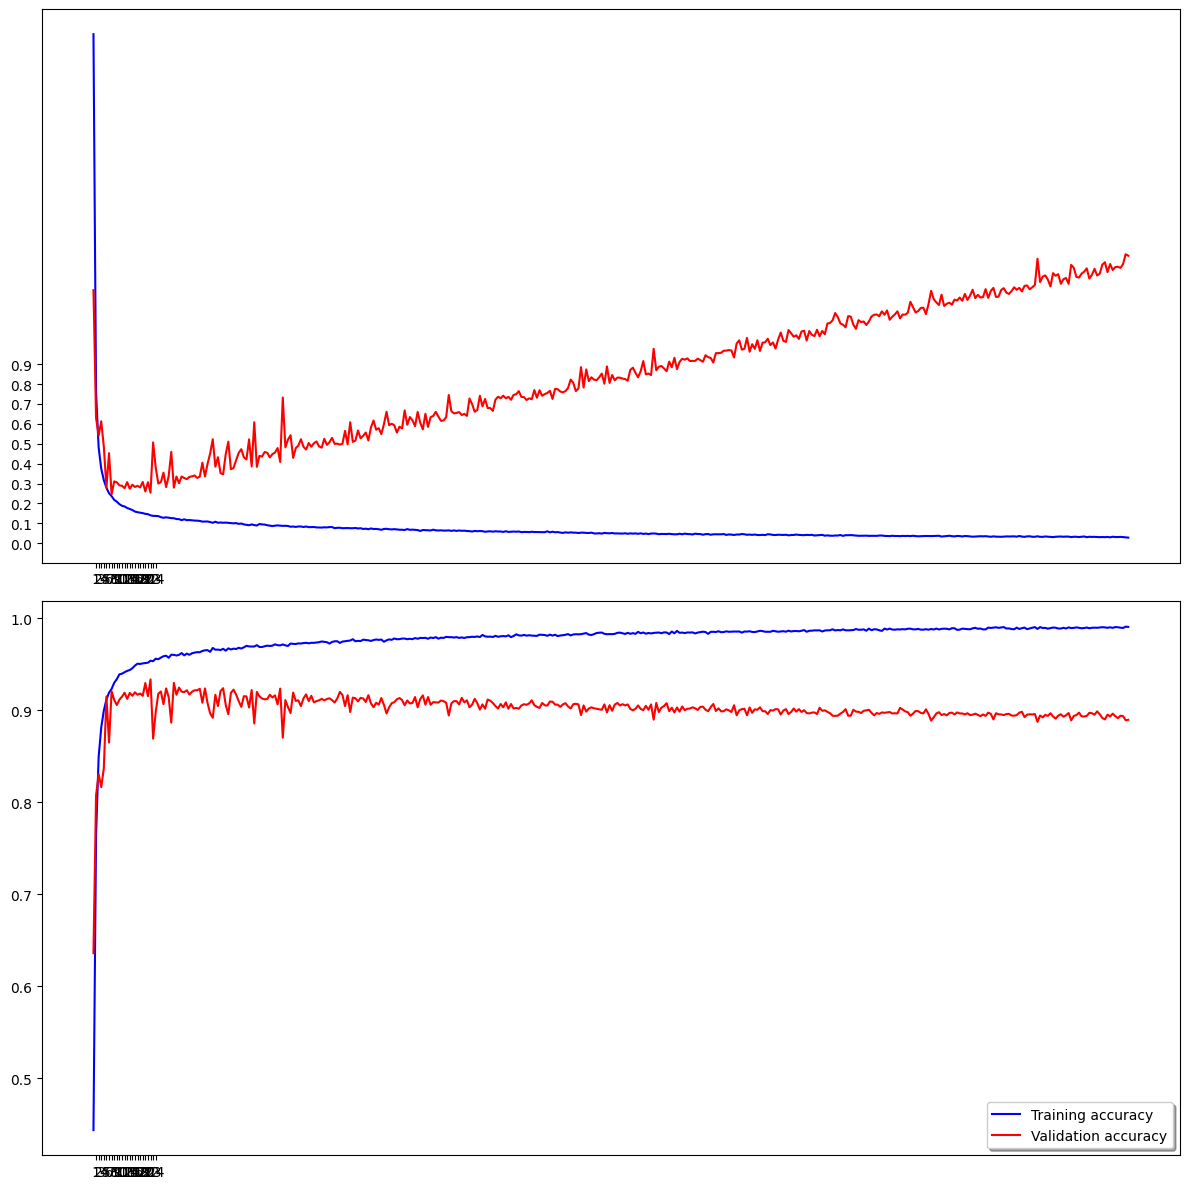

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis

Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created 

In [20]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig


In [21]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels,predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)


In [22]:
ypred = VGG16_model.predict(valid_vgg16)

valid_list = valid_data.classes.tolist()

ypred_class = np.argmax(ypred,axis=1)
ytest = valid_list

141/141 [==============================] - 0s 549us/step


In [23]:
class_names = list()
for name,idx in valid_data.class_indices.items():
    class_names.append(name)
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


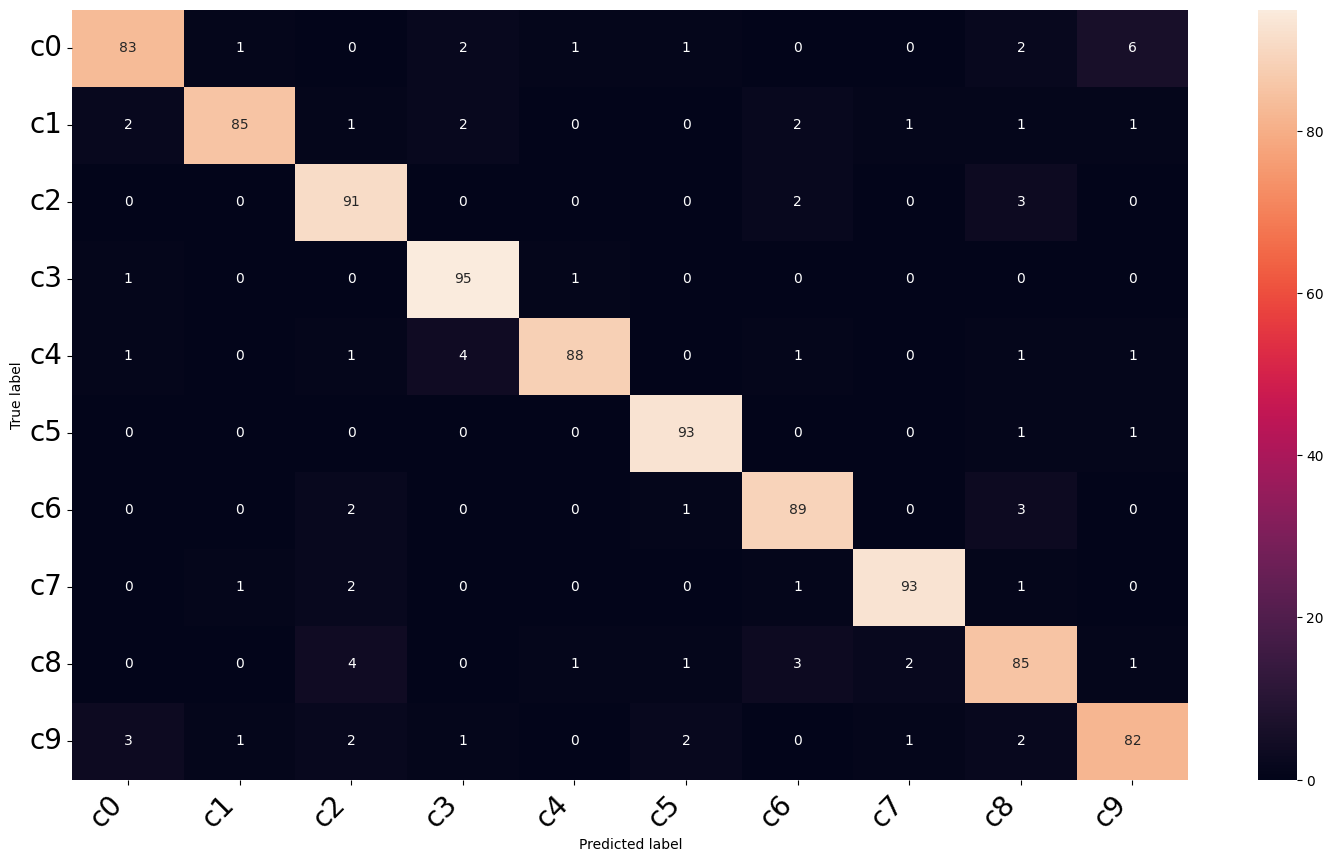

In [24]:
print_heatmap(ytest,ypred,class_names)

## Precision Recall F1 Score

In [26]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.889534
Precision: 0.891218
Recall: 0.889534
F1 score: 0.889560
